# BMI Topography to GRASS GIS

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from bmi_topography import Topography

In [2]:
import subprocess
import sys

# Ask GRASS GIS where its Python packages are.

# FOR WINDOWS:
grass_call = "grass82"
shell_setting = True

# FOR MAC/LINUX
# grass_call = "grass"
# shell_setting = False

sys.path.append(
    subprocess.check_output([grass_call, "--config", "python_path"], text=True, shell=shell_setting).strip()
)

In [3]:
# Import GRASS packages
import grass.script as gs
import grass.script.array as garray
import grass.jupyter as gj

In [4]:
# Start GRASS Session
gj.init("/path-to-data/landlab_colorado/PERMANENT/")

In [5]:
print(gs.read_command("g.region", flags="p"))

projection: 1 (UTM)
zone:       13
datum:      wgs84
ellipsoid:  wgs84
north:      1
south:      0
west:       0
east:       1
nsres:      1
ewres:      1
rows:       1
cols:       1
cells:      1



In [6]:
width = 0.05
dem = Topography(
    north=40.16 + width,
    south=40.14 - width,
    east=-105.4 + width,
    west=-105.5 - width,
    dem_type="SRTMGL3",
    output_format="GTiff"
)

C:\Users\caitl\AppData\Roaming\Python\Python39\site-packages\bmi_topography\api_key.py:49: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.readthedocs.io/en/latest/#api-key for more information.
  warnings.warn(


In [ ]:
dem.cache_dir

In [8]:
from pathlib import Path

file = Path(f"{dem.cache_dir}/{dem.dem_type}_{dem.bbox.south}_{dem.bbox.west}_{dem.bbox.north}_{dem.bbox.east}.tif")

In [9]:
gs.run_command("r.import", input=file, output="dem")

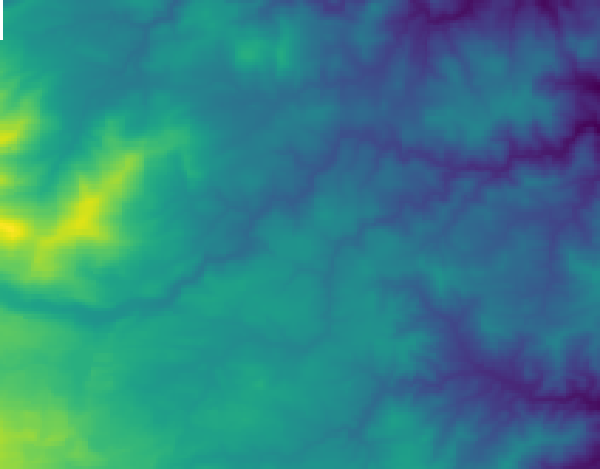

In [10]:
omg = gj.Map()
omg.d_rast(map="dem")
omg.show()